In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:\\Users\\Maxcell-HomePC\\QishiQR')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *
from Backtesting.Vectorized.models import *

from Utils.lm import gen_strategy, LM_model
from Utils.MajorContract_split import MajorContracts

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('../config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']
Major_DIR = config['Major path']
model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Zn test

## Build time series of Major contracts without thresholding the price movements

In [2]:
zn_mj = MajorContracts(symbol='zn', split_time='2016-7-1', topdir='C:\\Users\\Maxcell-HomePC\\QishiQR\\Data', 
                       maturity={'1603':['2016-1-1','2016-2-29'],
                                 '1604':['2016-2-1','2016-3-31'],
                                 '1605':['2016-3-1','2016-4-30'],
                                 '1606':['2016-4-1','2016-5-31'],
                                 '1607':['2016-5-1','2016-6-30'],
                                 '1608':['2016-6-1','2016-7-31'],
                                 '1609':['2016-7-1','2016-8-31'],
                                 '1610':['2016-8-1','2016-9-30'],
                                 '1611':['2016-9-1','2016-10-31'],
                                 '1612':['2016-10-1','2016-11-30'],
                                 '1701':['2016-11-1','2016-12-31'],
                                 '1702':['2016-12-1','2017-1-31']
                                },
                       transitions = {'1603':'2016-2-1', 
                                      '1604':'2016-3-1', 
                                      '1605':'2016-4-1',
                                      '1606':'2016-5-1',
                                      '1607':'2016-6-1',
                                      '1608':'2016-7-1',
                                      '1609':'2016-8-1',
                                      '1610':'2016-9-1',
                                      '1611':'2016-10-1',
                                      '1612':'2016-11-1',
                                      '1701':'2016-12-1',
                                      '1702':'2017-1-1'
                                     },
                       freq=freq, offset=offset)

df_zn_train, df_zn_test, ptb = zn_mj.create_major_overlap()

strategy = list(ptb.values())
slm = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

zn1603 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1603 ['2016-1-1', '2016-2-29'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160130.0
zn1604 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1604 ['2016-2-1', '2016-3-31'] 2016-02-01 00:00:00 2016-03-01 00:00:00
probability table:  20160130.0 20160229.0
zn1605 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1605 ['2016-3-1', '2016-4-30'] 2016-03-01 00:00:00 2016-04-01 00:00:00
probability table:  20160229.0 20160331.0
zn1606 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1606 ['2016-4-1', '2016-5-31'] 2016-04-01 00:00:00 2016-05-01 00:00:00
probability table:  20160331.0 20160429.0
zn1607 C:\Users\wqiang\QishiQR\Data/zn
0
ID trade_range transition_begin transition_end
1607 ['2016-5-1', '2016-6-30'] 2016-05-01 00:00:00 2016-06-01 00:00:00
probability table:  20160503.0 201605

## price change distribution

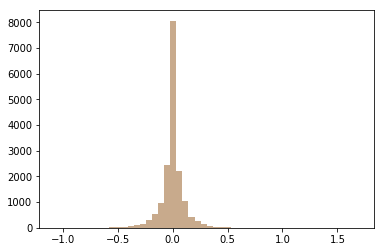

In [6]:
import seaborn as sns
zn_pct_change_train = df_zn_train.LastPrice.pct_change().dropna().values*100
sns.distplot(zn_pct_change_train, kde=False)
plt.show()

Calcualte the standard deviation of price change:

In [7]:
np.std(zn_pct_change_train)

0.1129395974200197

## Build time series of Major contracts with thresholding the price movements
### 0.05% threshold
Since the std of the price change is ~ 0.2%, we choose to use 0.1% as the threshold of price movements.

In [3]:
zn_mj_th0 = MajorContracts(symbol='zn', split_time='2016-7-1', topdir='C:\\Users\\Maxcell-HomePC\\QishiQR\\Data', 
                       maturity={'1603':['2016-1-1','2016-2-29'],
                                 '1604':['2016-2-1','2016-3-31'],
                                 '1605':['2016-3-1','2016-4-30'],
                                 '1606':['2016-4-1','2016-5-31'],
                                 '1607':['2016-5-1','2016-6-30'],
                                 '1608':['2016-6-1','2016-7-31'],
                                 '1609':['2016-7-1','2016-8-31'],
                                 '1610':['2016-8-1','2016-9-30'],
                                 '1611':['2016-9-1','2016-10-31'],
                                 '1612':['2016-10-1','2016-11-30'],
                                 '1701':['2016-11-1','2016-12-31'],
                                 '1702':['2016-12-1','2017-1-31']
                                },
                       transitions = {'1603':'2016-2-1', 
                                      '1604':'2016-3-1', 
                                      '1605':'2016-4-1',
                                      '1606':'2016-5-1',
                                      '1607':'2016-6-1',
                                      '1608':'2016-7-1',
                                      '1609':'2016-8-1',
                                      '1610':'2016-9-1',
                                      '1611':'2016-10-1',
                                      '1612':'2016-11-1',
                                      '1701':'2016-12-1',
                                      '1702':'2017-1-1'
                                     },
                       freq=freq, offset=offset, px_th=0.05/100)

df_zn_train_th_0, df_zn_test_th_0, ptb_th_0 = zn_mj_th0.create_major_overlap()

strategy = list(ptb_th_0.values())
slm_th_0 = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm_th_0['signal'] = slm_th_0.loc[:, '0':'2'].idxmax(axis=1)

zn1603 C:\Users\wqiang\QishiQR\Data/zn
0.0005
ID trade_range transition_begin transition_end
1603 ['2016-1-1', '2016-2-29'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160130.0
zn1604 C:\Users\wqiang\QishiQR\Data/zn
0.0005
ID trade_range transition_begin transition_end
1604 ['2016-2-1', '2016-3-31'] 2016-02-01 00:00:00 2016-03-01 00:00:00
probability table:  20160130.0 20160229.0
zn1605 C:\Users\wqiang\QishiQR\Data/zn
0.0005
ID trade_range transition_begin transition_end
1605 ['2016-3-1', '2016-4-30'] 2016-03-01 00:00:00 2016-04-01 00:00:00
probability table:  20160229.0 20160331.0
zn1606 C:\Users\wqiang\QishiQR\Data/zn
0.0005
ID trade_range transition_begin transition_end
1606 ['2016-4-1', '2016-5-31'] 2016-04-01 00:00:00 2016-05-01 00:00:00
probability table:  20160331.0 20160429.0
zn1607 C:\Users\wqiang\QishiQR\Data/zn
0.0005
ID trade_range transition_begin transition_end
1607 ['2016-5-1', '2016-6-30'] 2016-05-01 00:00:00 2016-06-01 00:00:00
probability 

### 0.1% threshold


In [4]:
zn_mj_th1 = MajorContracts(symbol='zn', split_time='2016-7-1', topdir='C:\\Users\\Maxcell-HomePC\\QishiQR\\Data', 
                       maturity={'1603':['2016-1-1','2016-2-29'],
                                 '1604':['2016-2-1','2016-3-31'],
                                 '1605':['2016-3-1','2016-4-30'],
                                 '1606':['2016-4-1','2016-5-31'],
                                 '1607':['2016-5-1','2016-6-30'],
                                 '1608':['2016-6-1','2016-7-31'],
                                 '1609':['2016-7-1','2016-8-31'],
                                 '1610':['2016-8-1','2016-9-30'],
                                 '1611':['2016-9-1','2016-10-31'],
                                 '1612':['2016-10-1','2016-11-30'],
                                 '1701':['2016-11-1','2016-12-31'],
                                 '1702':['2016-12-1','2017-1-31']
                                },
                       transitions = {'1603':'2016-2-1', 
                                      '1604':'2016-3-1', 
                                      '1605':'2016-4-1',
                                      '1606':'2016-5-1',
                                      '1607':'2016-6-1',
                                      '1608':'2016-7-1',
                                      '1609':'2016-8-1',
                                      '1610':'2016-9-1',
                                      '1611':'2016-10-1',
                                      '1612':'2016-11-1',
                                      '1701':'2016-12-1',
                                      '1702':'2017-1-1'
                                     },
                       freq=freq, offset=offset, px_th=0.1/100)

df_zn_train_th_1, df_zn_test_th_1, ptb_th_1 = zn_mj_th1.create_major_overlap()

strategy = list(ptb_th_1.values())
slm_th_1 = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm_th_1['signal'] = slm_th_1.loc[:, '0':'2'].idxmax(axis=1)

zn1603 C:\Users\wqiang\QishiQR\Data/zn
0.001
ID trade_range transition_begin transition_end
1603 ['2016-1-1', '2016-2-29'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160130.0
zn1604 C:\Users\wqiang\QishiQR\Data/zn
0.001
ID trade_range transition_begin transition_end
1604 ['2016-2-1', '2016-3-31'] 2016-02-01 00:00:00 2016-03-01 00:00:00
probability table:  20160130.0 20160229.0
zn1605 C:\Users\wqiang\QishiQR\Data/zn
0.001
ID trade_range transition_begin transition_end
1605 ['2016-3-1', '2016-4-30'] 2016-03-01 00:00:00 2016-04-01 00:00:00
probability table:  20160229.0 20160331.0
zn1606 C:\Users\wqiang\QishiQR\Data/zn
0.001
ID trade_range transition_begin transition_end
1606 ['2016-4-1', '2016-5-31'] 2016-04-01 00:00:00 2016-05-01 00:00:00
probability table:  20160331.0 20160429.0
zn1607 C:\Users\wqiang\QishiQR\Data/zn
0.001
ID trade_range transition_begin transition_end
1607 ['2016-5-1', '2016-6-30'] 2016-05-01 00:00:00 2016-06-01 00:00:00
probability table

### 0.2% threhold 

In [5]:
zn_mj_th2 = MajorContracts(symbol='zn', split_time='2016-7-1', topdir='C:\\Users\\Maxcell-HomePC\\QishiQR\\Data', 
                       maturity={'1603':['2016-1-1','2016-2-29'],
                                 '1604':['2016-2-1','2016-3-31'],
                                 '1605':['2016-3-1','2016-4-30'],
                                 '1606':['2016-4-1','2016-5-31'],
                                 '1607':['2016-5-1','2016-6-30'],
                                 '1608':['2016-6-1','2016-7-31'],
                                 '1609':['2016-7-1','2016-8-31'],
                                 '1610':['2016-8-1','2016-9-30'],
                                 '1611':['2016-9-1','2016-10-31'],
                                 '1612':['2016-10-1','2016-11-30'],
                                 '1701':['2016-11-1','2016-12-31'],
                                 '1702':['2016-12-1','2017-1-31']
                                },
                       transitions = {'1603':'2016-2-1', 
                                      '1604':'2016-3-1', 
                                      '1605':'2016-4-1',
                                      '1606':'2016-5-1',
                                      '1607':'2016-6-1',
                                      '1608':'2016-7-1',
                                      '1609':'2016-8-1',
                                      '1610':'2016-9-1',
                                      '1611':'2016-10-1',
                                      '1612':'2016-11-1',
                                      '1701':'2016-12-1',
                                      '1702':'2017-1-1'
                                     },
                       freq=freq, offset=offset, px_th=0.2/100)

df_zn_train_th_2, df_zn_test_th_2, ptb_th_2 = zn_mj_th2.create_major_overlap()

strategy = list(ptb_th_0.values())
slm_th_2 = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm_th_2['signal'] = slm_th_2.loc[:, '0':'2'].idxmax(axis=1)

zn1603 C:\Users\wqiang\QishiQR\Data/zn
0.002
ID trade_range transition_begin transition_end
1603 ['2016-1-1', '2016-2-29'] 2016-01-01 00:00:00 2016-02-01 00:00:00
probability table:  20160104.0 20160130.0
zn1604 C:\Users\wqiang\QishiQR\Data/zn
0.002
ID trade_range transition_begin transition_end
1604 ['2016-2-1', '2016-3-31'] 2016-02-01 00:00:00 2016-03-01 00:00:00
probability table:  20160130.0 20160229.0
zn1605 C:\Users\wqiang\QishiQR\Data/zn
0.002
ID trade_range transition_begin transition_end
1605 ['2016-3-1', '2016-4-30'] 2016-03-01 00:00:00 2016-04-01 00:00:00
probability table:  20160229.0 20160331.0
zn1606 C:\Users\wqiang\QishiQR\Data/zn
0.002
ID trade_range transition_begin transition_end
1606 ['2016-4-1', '2016-5-31'] 2016-04-01 00:00:00 2016-05-01 00:00:00
probability table:  20160331.0 20160429.0
zn1607 C:\Users\wqiang\QishiQR\Data/zn
0.002
ID trade_range transition_begin transition_end
1607 ['2016-5-1', '2016-6-30'] 2016-05-01 00:00:00 2016-06-01 00:00:00
probability table

# Compare two generated probability tables

## TBD
------


# test on major contract
## No threshold

In [6]:
from Backtesting.Vectorized.models import OneContractTest

start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test1 = MajorSeriesTest(df_zn_test, OUTPUT_DIR,slm)
test1.build( max_order, offset, start, end, tcas)

test1.run()

test1.plot()
test1.results[0]['benchmark'].plot()
plt.legend()
test1.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.310171,0.000821,-0.002744,0.001504,0.000017,-0.054822,0.019105,-0.129808,0.548062,0.661815,3459,1.058298,0.500723
1,0.312977,0.000465,-0.002943,0.001501,0.000012,-0.054822,0.019105,-0.131654,0.509834,0.371251,2833,1.032999,0.635722
2,0.304788,0.000536,-0.002973,0.001547,0.000014,-0.055774,0.019105,-0.136612,0.520533,0.439499,2652,1.038043,0.648190
3,0.308329,0.000148,-0.002823,0.001601,0.000004,-0.054822,0.025530,-0.162334,0.566976,0.120083,2714,1.010515,0.625645
4,0.280036,-0.000649,-0.002790,0.001604,-0.000016,-0.054822,0.019105,-0.172822,0.575045,-0.579610,2827,0.953904,0.591440
5,0.347151,-0.002003,-0.002566,0.001783,-0.000048,-0.050765,0.020268,-0.239983,0.694853,-1.442181,2944,0.857814,0.509171
6,0.321233,-0.001657,-0.002448,0.001894,-0.000037,-0.035736,0.023063,-0.187542,0.773562,-1.289925,3152,0.882320,0.456853


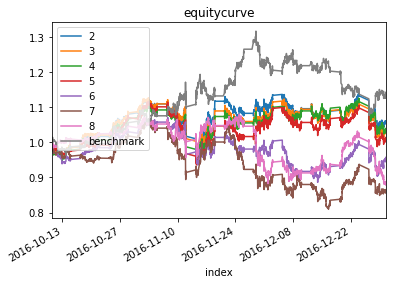

In [7]:
plt.show()

In [8]:
start = '20160601'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test2 = MajorSeriesTest(df_zn_test, OUTPUT_DIR,slm)
test2.build( max_order, offset, start, end, tcas)

test2.run()

test2.plot()
test2.results[0]['benchmark'].plot()
plt.legend()
test2.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.243949,0.002279,-0.002106,0.001184,0.000045,-0.054822,0.019105,-0.104163,0.562479,2.335725,7445,1.335041,0.472129
1,0.247523,0.002396,-0.002237,0.001169,0.000060,-0.054822,0.019105,-0.102608,0.522528,2.419558,5875,1.352151,0.634043
2,0.240026,0.002489,-0.002255,0.001209,0.000067,-0.055774,0.019105,-0.105399,0.536256,2.592521,5450,1.365896,0.651560
3,0.243998,0.001488,-0.002154,0.001263,0.000040,-0.054822,0.025530,-0.136839,0.586124,1.524354,5515,1.218700,0.623209
4,0.239423,0.000555,-0.002100,0.001277,0.000014,-0.054822,0.019105,-0.154413,0.607953,0.579818,5907,1.081627,0.576096
5,0.271643,0.000261,-0.001933,0.001391,0.000006,-0.050765,0.020268,-0.205205,0.719640,0.239986,6254,1.038332,0.502558
6,0.247814,-0.000721,-0.001860,0.001492,-0.000016,-0.035736,0.023063,-0.185545,0.802103,-0.727805,6601,0.893948,0.430995


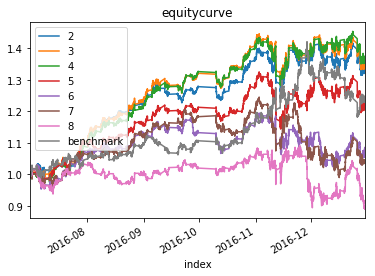

In [9]:
plt.show()

### 0.05% Threshold

In [10]:
start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test7 = MajorSeriesTest(df_zn_test_th_0, OUTPUT_DIR,slm_th_0)
test7.build( max_order, offset, start, end, tcas)

test7.run()

test7.plot()
test7.results[0]['benchmark'].plot()
plt.legend()
test7.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
1,2.340752e-01,0.001473,-0.002836,0.001517,0.000041,-0.050765,0.020268,-0.113245,0.534991,1.572922,2524,1.104564,0.304279
2,2.351573e-01,0.001357,-0.002797,0.001487,0.000036,-0.050765,0.020268,-0.112357,0.531488,1.442717,2652,1.096351,0.304676
3,2.342328e-01,0.000892,-0.002018,0.001588,0.000020,-0.049329,0.020268,-0.098928,0.786835,0.952205,3147,1.063343,0.270734
4,2.029283e-01,0.000926,-0.002129,0.001806,0.000021,-0.025770,0.023650,-0.109419,0.848444,1.140503,3165,1.065729,0.279621
5,2.253238e-01,-0.001777,-0.002124,0.001722,-0.000035,-0.022755,0.022795,-0.205688,0.810734,-1.971099,3604,0.873865,0.284961
6,2.543339e-01,-0.001113,-0.002055,0.001751,-0.000023,-0.022873,0.018958,-0.222681,0.852332,-1.093851,3387,0.920990,0.290818


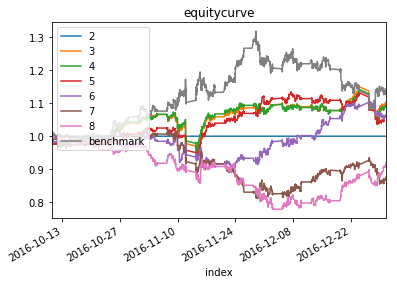

In [11]:
plt.show()

## 0.1% threshold in price movements

In [12]:
from Backtesting.Vectorized.models import OneContractTest

start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test3 = MajorSeriesTest(df_zn_test_th_1, OUTPUT_DIR,slm_th_1)
test3.build( max_order, offset, start, end, tcas)

test3.run()

test3.plot()
test3.results[0]['benchmark'].plot()
plt.legend()
test3.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
1,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
2,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
3,1.205469e-01,-0.002337,-0.001901,0.001712,-0.000115,-0.015022,0.014312,-0.167575,0.900706,-4.845742,1439,0.834104,0.232801
4,1.749526e-01,-0.000243,-0.001963,0.001784,-0.000006,-0.015022,0.014168,-0.112383,0.908445,-0.346627,2679,0.982777,0.288541
5,1.624557e-01,-0.001071,-0.001859,0.001618,-0.000027,-0.015022,0.018811,-0.148504,0.869961,-1.647769,2860,0.923976,0.252448
6,1.587067e-01,-0.000767,-0.001946,0.001897,-0.000028,-0.013023,0.018811,-0.107120,0.974650,-1.207660,1921,0.945567,0.245705


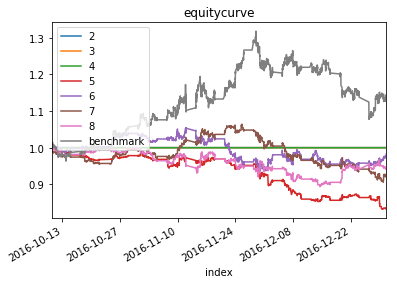

In [13]:
plt.show()

In [16]:
start = '20160601'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test4 = MajorSeriesTest(df_zn_test_th_1, OUTPUT_DIR,slm_th_1)
test4.build( max_order, offset, start, end, tcas)

test4.run()

test4.plot()
test4.results[0]['benchmark'].plot()
plt.legend()
test4.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
1,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
2,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
3,9.902233e-02,-0.001104,-0.001568,0.001374,-0.000060,-0.015022,0.014312,-0.195906,0.876603,-2.786374,2702,0.837763,0.235381
4,1.463772e-01,0.000144,-0.001602,0.001407,0.000004,-0.015022,0.014168,-0.108438,0.878245,0.245462,5140,1.021127,0.280934
5,1.301294e-01,-0.000412,-0.001497,0.001270,-0.000011,-0.015022,0.018811,-0.146385,0.848669,-0.792216,5654,0.939383,0.251857
6,1.279267e-01,-0.000353,-0.001476,0.001409,-0.000013,-0.013023,0.018811,-0.140228,0.954837,-0.690007,4080,0.948097,0.245098


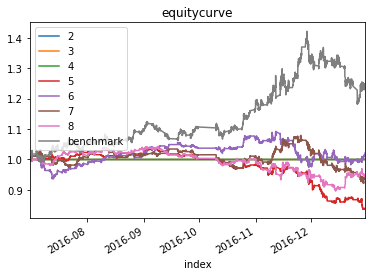

In [17]:
plt.show()

## 0.2% threshold in price movements

In [18]:
from Backtesting.Vectorized.models import OneContractTest

start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test5 = MajorSeriesTest(df_zn_test_th_2, OUTPUT_DIR,slm_th_2)
test5.build( max_order, offset, start, end, tcas)

test5.run()

test5.plot()
test5.results[0]['benchmark'].plot()
plt.legend()
test5.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
1,2.340752e-01,0.001473,-0.002836,0.001517,0.000041,-0.050765,0.020268,-0.113245,0.534991,1.572922,2524,1.104564,0.304279
2,2.351573e-01,0.001357,-0.002797,0.001487,0.000036,-0.050765,0.020268,-0.112357,0.531488,1.442717,2652,1.096351,0.304676
3,2.342328e-01,0.000892,-0.002018,0.001588,0.000020,-0.049329,0.020268,-0.098928,0.786835,0.952205,3147,1.063343,0.270734
4,2.029283e-01,0.000926,-0.002129,0.001806,0.000021,-0.025770,0.023650,-0.109419,0.848444,1.140503,3165,1.065729,0.279621
5,2.253238e-01,-0.001777,-0.002124,0.001722,-0.000035,-0.022755,0.022795,-0.205688,0.810734,-1.971099,3604,0.873865,0.284961
6,2.543339e-01,-0.001113,-0.002055,0.001751,-0.000023,-0.022873,0.018958,-0.222681,0.852332,-1.093851,3387,0.920990,0.290818


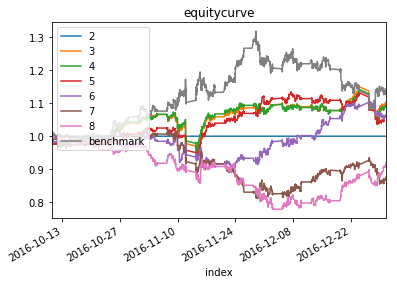

In [19]:
plt.show()

In [20]:
start = '20160601'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test6 = MajorSeriesTest(df_zn_test_th_2, OUTPUT_DIR,slm_th_2)
test6.build( max_order, offset, start, end, tcas)

test6.run()

test6.plot()
test6.results[0]['benchmark'].plot()
plt.legend()
test6.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,1.000000e-07,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1,1.000000,0.000000
1,1.753163e-01,0.001460,-0.002269,0.001213,0.000043,-0.050765,0.020268,-0.102658,0.534355,2.081948,4942,1.214620,0.297855
2,1.782608e-01,0.001356,-0.002259,0.001190,0.000038,-0.050765,0.020268,-0.102512,0.526712,1.902320,5228,1.199396,0.298967
3,1.804521e-01,0.001109,-0.001631,0.001272,0.000026,-0.049329,0.020268,-0.091639,0.779845,1.536685,6229,1.163051,0.264729
4,1.626427e-01,0.001014,-0.001661,0.001413,0.000024,-0.025770,0.023650,-0.109277,0.850704,1.558113,6338,1.149008,0.272957
5,1.765079e-01,-0.000596,-0.001638,0.001383,-0.000012,-0.022755,0.022795,-0.206124,0.843858,-0.844074,7310,0.912396,0.275513
6,1.990592e-01,-0.000360,-0.001575,0.001376,-0.000008,-0.022873,0.018958,-0.262893,0.873854,-0.452371,7019,0.947051,0.279669


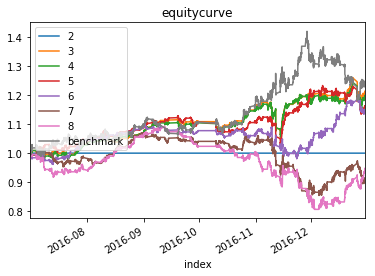

In [21]:
plt.show()